In [1]:
import os
import re
import json
results = {}
with open('./results.json', 'r', encoding='utf-8') as f:
    results = json.load(f)
    
codigos = results.keys()

In [2]:

# result = { 
#     "pontuacao" : None,
#     "n_subtarefas" : None,
#     "subtarefas100" : None,
#     "tempo_lim" : None,
#     "mem_lim" : None,
#     "tempo" : None,
#     "mem" : None,
#     "comp" : None,
#     "stderr" : None 
# }
list_error = []
list_warning = []
list_accepted = []
list_TLE = []
list_MLE = []
for codigo in codigos:
    data = results[codigo]
    if not data["comp"]:
        list_error.append(codigo)
        continue
    if len(data["stderr"])>1:
        list_warning.append(codigo)
    if data["pontuacao"] == 100:
        list_accepted.append(codigo)
    if data["tempo"] >= data["tempo_lim"]:
        list_TLE.append(codigo)
    if data["mem"] >= data["mem_lim"]:
        list_MLE.append(codigo)



    
        

In [3]:
def count_words(text):
    return len(re.findall(r'\S+', text))
def get_info(info, codigo):
    info[codigo] = {
        "len_enunciado": None,
        "len_entrada": None,
        "len_saida": None,
        "n_restricoes": None,
        "n_exemplos": None
    }
    text = ''
    with open(f'./pratique/{codigo}/{codigo}.txt', 'r', encoding='utf-8') as f:
        text = f.read()
    data = info[codigo]
    sections = re.split(r'\n\s*Entrada\s*\n',text)
    enunciado = ''.join(sections[:2])
    data["len_enunciado"] = count_words(enunciado)
    n_exemplos = len(sections)-2
    len_entrada = 0
    len_saida = 0
    if n_exemplos > 0:
        for section in sections [2:]:
            splitted = re.split(r'\n\s*Saída\s*\n',section) # verificado se existe string 'Saida' nos textos # verificado se as strings procuradas existem nos textos
            entrada = splitted[0]
            try:
                saida = splitted[1]
            except: # quebra em caso de entrada vazia
                print(f'{codigo} com entrada vazia.')
                return
            if len(entrada.strip()) == 0 or len(saida.strip()) == 0:
                print(f'{codigo} com entrada ou saida vazia.')
                return
            len_entrada += count_words(entrada)
            len_saida += count_words(saida)
        len_entrada /= n_exemplos
        len_saida /= n_exemplos
        data["len_entrada"] = len_entrada
        data["len_saida"] = len_saida
    data["n_exemplos"] = n_exemplos
    data["n_restricoes"] = enunciado.count('≤')+enunciado.count('≥')
info = {}
for codigo in codigos:
    get_info(info, codigo)

 
        

In [4]:
comentarios = {}
def get_comentarios(comentarios, codigo):
    with open(f'./pratique/{codigo}/{codigo}.cpp', 'r', encoding='utf-8') as f:
        code = f.read()
    search = re.findall(r'(//.*?$|/\*.*?\*/)', code, re.DOTALL | re.MULTILINE)
    if len(search) > 0:
        comentarios[codigo] = search
for codigo in codigos:
    get_comentarios(comentarios, codigo)


In [5]:
contain_image = []
with open('./pratique/contain_image.json', 'r', encoding='utf-8') as f:
    contain_image = json.load(f)

In [14]:
print(list_TLE[0])

2007_p1_f2_metro


In [21]:
# Importando bibliotecas necessárias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.interpolate import make_interp_spline

# Configurações globais para os gráficos
sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams["font.size"] = 12

# Convertendo os dicionários em DataFrames para facilitar a análise
results_df = pd.DataFrame.from_dict(results, orient="index")
info_df = pd.DataFrame.from_dict(info, orient="index")

# Unindo os dois DataFrames
data = results_df.join(info_df)
data["edicao"] = data.index.str.split("_").str[0]
data["nivel"] = data.index.str.split("_").str[1]
data["fase"] = data.index.str.split("_").str[2]
data["contain_image"] = data.index.isin(contain_image)
# Valid data: compilation success, not TLE, not MLE
comp_data = data[(data["comp"] == True)]



bins = [0, 5, 10, np.inf]
labels = ["1-5", "6-10", "11+"]


# Use .loc[] to create the new column
comp_data.loc[:, 'n_subtarefas_group'] = pd.cut(
    comp_data['n_subtarefas'],
    bins=bins,
    labels=labels,
    right=True
)

noterror_data = comp_data[(~comp_data.index.isin(list_TLE)) & (~comp_data.index.isin(list_MLE))]
TLE_data = comp_data[(comp_data.index.isin(list_TLE))]
MLE_data = comp_data[(comp_data.index.isin(list_MLE))]



C:\Users\analc\AppData\Local\Temp\ipykernel_6528\411949720.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comp_data.loc[:, 'n_subtarefas_group'] = pd.cut(


In [22]:
data_true = data[data["contain_image"] == True]
data_false = data[data["contain_image"] == False]

def generate_pie(df, title):
    """Helper function to generate a pie chart."""
    comp_true = df["comp"].sum()
    tle = df.index.isin(list_TLE).sum()
    mle = df.index.isin(list_MLE).sum()
    other = len(df) - comp_true - tle - mle

    labels = ["comp=True", "TLE", "MLE", "Other"]
    sizes = [comp_true, tle, mle, other]

    plt.figure(figsize=(8, 8))
    plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
    plt.title(title)
    plt.axis('equal')
    plt.show()

# Generate pie chart for contain_image True
generate_pie(data_true, "Distribution for contain_image = True")

# Generate pie chart for contain_image False
generate_pie(data_false, "Distribution for contain_image = False")

c:\Users\analc\miniconda3\envs\envIC\Lib\site-packages\matplotlib\axes\_axes.py:3290: RuntimeWarning: invalid value encountered in divide
  x = x / sx


ValueError: cannot convert float NaN to integer

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


ValueError: need at least one array to concatenate

<Figure size 800x800 with 1 Axes>

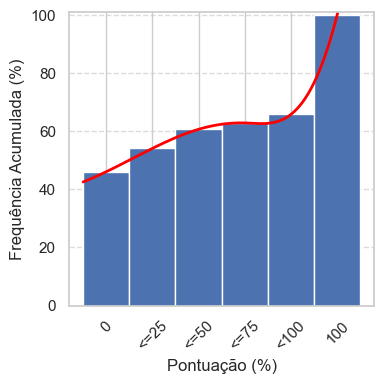

In [16]:
data_column = comp_data["pontuacao"]
bins = [0, 25, 50, 75, 100]
labels = ['0', '<=25', '<=50', '<=75', '<100', '100']

counts = [
    (data_column == 0).sum(),
    ((data_column > 0) & (data_column <= 25)).sum(),
    ((data_column > 25) & (data_column <= 50)).sum(),
    ((data_column > 50) & (data_column <= 75)).sum(),
    ((data_column > 75) & (data_column < 100)).sum(),
    (data_column == 100).sum()
]

total_count = len(data_column)
percentages = [count / total_count * 100 for count in counts]
cumulative_percentages = np.cumsum(percentages)

# Create the plot
plt.figure(figsize=(4, 4))

# Bar plot (thinner and glued together)
bar_width = 1 
bar_positions = np.arange(len(labels)) 

plt.bar(bar_positions, cumulative_percentages, width=bar_width, align='edge')

# Ensure the last bin is included properly in the spline interpolation
x_vals = bar_positions + bar_width / 2  # Adjust x positions
y_vals = cumulative_percentages

# Smooth trend curve using spline interpolation
x_smooth = np.linspace(bar_positions.min(), bar_positions.max() + bar_width, 300)
spl = make_interp_spline(x_vals, y_vals, k=3)  # k=3 for cubic spline
y_smooth = spl(x_smooth)

plt.plot(x_smooth, y_smooth, color='red', linestyle='-', linewidth=2)

# Set labels and title
plt.ylim(0, 101)
plt.xlabel("Pontuação (%)")
plt.ylabel("Frequência Acumulada (%)")
plt.xticks(bar_positions + bar_width / 2, labels, rotation=45)  # Adjust xtick positions
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

C:\Users\analc\AppData\Local\Temp\ipykernel_6528\806254585.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  average_pontuacao = comp_data.groupby('n_subtarefas_group')['pontuacao'].mean()


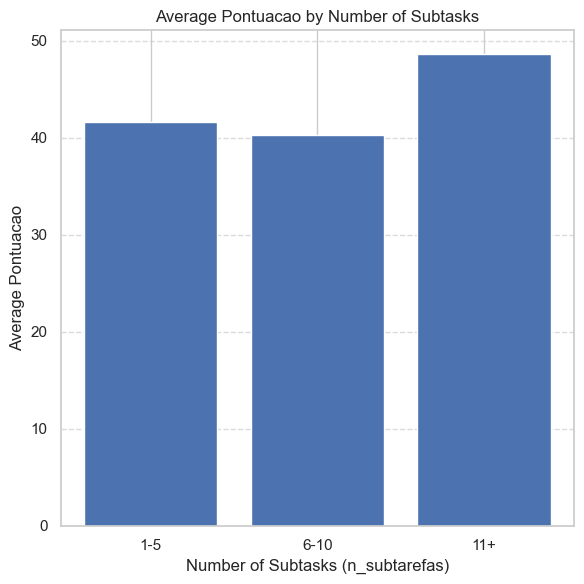

In [13]:
# 2) Porcentagens de acertos por quantidade de subtarefas

average_pontuacao = comp_data.groupby('n_subtarefas_group')['pontuacao'].mean()

plt.figure(figsize=(6, 6))
plt.bar(average_pontuacao.index, average_pontuacao.values)
plt.xlabel("Number of Subtasks (n_subtarefas)")
plt.ylabel("Average Pontuacao")
plt.title("Average Pontuacao by Number of Subtasks")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
# 3) Comparativo entre questões com e sem imagens
grouped_image = data.groupby("has_image").agg(
    pontuacao_media=("pontuacao", "mean"),
    erros=("comp", lambda x: (~x).sum()),
    TLE=("tempo", lambda x: x.isin(list_TLE).sum()),
    MLE=("mem", lambda x: x.isin(list_MLE).sum())
).reset_index()

plt.figure()
grouped_image.plot(kind="bar", x="has_image", stacked=True, color=["#4c72b0", "#55a868", "#c44e52"])
plt.title("Comparativo entre Questões com e sem Imagens")
plt.xlabel("Contém Imagem")
plt.ylabel("Média e Erros")
plt.tight_layout()
plt.show()



grouped_edicao = data.groupby(["edicao", "nivel", "fase"])["pontuacao"].mean().unstack()

plt.figure()
grouped_edicao.plot(kind="bar", cmap="viridis")
plt.title("Pontuação Média por Edição, Nível e Fase")
plt.xlabel("Edição, Nível e Fase")
plt.ylabel("Pontuação Média")
plt.tight_layout()
plt.show()

# 5) Porcentagem de TLE, MLE e erros de compilação por edição, nível e fase
verdict_counts = data.groupby(["edicao", "nivel", "fase"]).apply(
    lambda x: pd.Series({
        "TLE": x.index.isin(list_TLE).sum(),
        "MLE": x.index.isin(list_MLE).sum(),
        "Erro de Compilação": (~x["comp"]).sum()
    })
).reset_index()

verdict_counts_melted = verdict_counts.melt(
    id_vars=["edicao", "nivel", "fase"],
    value_vars=["TLE", "MLE", "Erro de Compilação"],
    var_name="Veredito",
    value_name="Quantidade"
)

plt.figure()
sns.barplot(data=verdict_counts_melted, x="edicao", y="Quantidade", hue="Veredito", palette="Set2")
plt.title("Porcentagem de Vereditos por Edição, Nível e Fase")
plt.xlabel("Edição, Nível e Fase")
plt.ylabel("Porcentagem")
plt.tight_layout()
plt.show()

# 6) Percentual de pontuação 100 por edição, nível e fase
accepted_counts = data.groupby(["edicao", "nivel", "fase"]).apply(
    lambda x: (x.index.isin(list_accepted).sum() / len(x)) * 100
).reset_index(name="Percentual de Pontuação 100")

plt.figure()
sns.barplot(data=accepted_counts, x="edicao", y="Percentual de Pontuação 100", hue="nivel", palette="coolwarm")
plt.title("Percentual de Pontuação 100 por Edição, Nível e Fase")
plt.xlabel("Edição, Nível e Fase")
plt.ylabel("Percentual (%)")
plt.tight_layout()
plt.show()

# 7) Relação entre tamanho do enunciado/entradas/saídas e pontuações/vereditos
plt.figure()
sns.pairplot(data, vars=["len_enunciado", "len_entrada", "len_saida", "pontuacao"], hue="comp", palette="husl")
plt.suptitle("Relação entre Tamanho do Enunciado/Entradas/Saídas e Pontuações")
plt.tight_layout()
plt.show()